In [336]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from utils.basic_utils import *
from utils.pricing import *
from utils.imports import *
from utils.structured import *

pd.options.display.float_format = '{:,.2f}'.format

### Get universe pricing

In [339]:
# TAKES ~8m on 1230 companies, do once and persist
excl_list = ['BHF', 'ERI']
symbols_list = len(excl(config['companies'], excl_list))
# %time px_close = get_mults_pricing(symbols_list)

In [1329]:
os.makedirs('tmp', exist_ok=True)
px_close.to_parquet('tmp/mult-co-px-ds')

In [17]:
px_close = pd.read_parquet('tmp/mult-co-px-ds')

In [18]:
px_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3906 entries, 2004-03-08 00:00:00-05:00 to 2019-03-07 00:00:00-05:00
Columns: 1230 entries, 1810.HK to 0700.HK
dtypes: float64(1230)
memory usage: 36.7 MB


In [ ]:
px_close.describe()

In [39]:
quotes = load_csvs('quote_consol', tgt_date)
quotes.set_index('symbol', drop=False, inplace=True)
profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Loading file quote/csv/2019-03-08
Loading file summary-categories/assetProfile


In [ ]:
quotes.describe(include='all')

In [ ]:
profile.describe(include='all')
show = ['symbol', 'sector', 'industry']
# profile[profile.city == 'New York'][show].sort_values(by='sector')

In [35]:
path_date = 'summary-categories/financialData/2019-03-07'
summ_categ = pd.read_csv(csv_load(path_date))
summ_categ.set_index('symbol', drop=False, inplace=True)

In [ ]:
summ_categ[summ_categ.symbol.isin(all_equities)].describe(include='all').T

In [70]:
profile.drop(profile[profile.symbol.isin(excl_list)].index, inplace=True)

all_equities = quotes[quotes.quoteType == 'EQUITY'].symbol.unique()
print('Delta quote: ', set(symbols_list) - set(all_equities))
# reduced subset, if any
sub_equities = set(px_close.columns.tolist()).intersection(all_equities)
print('Delta reduced set: ', set(symbols_list) - set(sub_equities))

eqty_symbols = profile[profile.symbol.isin(sub_equities)].symbol.unique().tolist()
delta_symb = set(symbols_list) - set(eqty_symbols)
print('Delta profile: ', len(delta_symb), delta_symb)

Delta quote:  {'FBR', 'PD', 'SCG'}
Delta reduced set:  {'FBR', 'PD', 'SCG'}
Delta profile:  23 {'ROP', 'ESL', '9984.T', 'LRCX', 'KORS', 'IBKR', 'JBT', 'ODFL', 'TAP', 'WSM', 'ABMD', 'CBOE', 'PD', 'SHPG', 'BSTI', 'DNB', 'AMED', 'VVC', 'FBR', 'SCG', 'DRE', 'NFX', 'REGN'}


In [71]:
# Create a frame of market, sector and industry index (once)
# for relative performance calculations
sel_profiles = profile[profile.symbol.isin(all_equities)]
sel_profiles.groupby(['sector', 'industry'])[['industry']].count()
sectors = sel_profiles.sector.unique()
industries = sel_profiles.industry.unique()

f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}'

'Sectors: 11, Industries: 136'

In [72]:
print('Equal weight index for: %s, %s, %d, %s' % ('IDX', 'Long Name', 4, ['A', 'B']))

Equal weight index for: IDX, Long Name, 4, ['A', 'B']


In [73]:
def eq_wgt_indices(px_df, col, group_list, tail=70**2, subset=None):
    names = []
    indices_df = pd.DataFrame()
    for s in group_list:
        idx_ticker = shorten_name(s)
        names.append(idx_ticker)
        symbols = profile[profile[col] == s].symbol.tolist()
#         print('Equal weight index for: %s, %s, %d, %s\n' \
#               % (idx_ticker, s, len(symbols), symbols))
        if subset: symbols = list(set(symbols).intersection(all_equities))
        index = get_ind_index(px_df[symbols], '1d', tail, idx_ticker)[[idx_ticker]]
        if len(indices_df) == 0: 
            indices_df = pd.DataFrame(index)
            continue
        indices_df = pd.concat([indices_df, index], axis=1)
    assert len(names) == len(set(names))
    return indices_df

In [74]:
%%time
indices_df = pd.concat([
    eq_wgt_indices(px_close, 'sector', sectors, subset=eqty_symbols),
    eq_wgt_indices(px_close, 'industry', industries, subset=eqty_symbols),
    to_index_form(get_symbol_pricing(bench, freq, 'close'), bench)
], axis=1)

CPU times: user 11.1 s, sys: 2.12 s, total: 13.2 s
Wall time: 3.97 s


In [113]:
def px_mom_co_feats(df, ind_df, 
                    groups=('Bench', 'Sector','Industry'), 
                    rolls=[20,60,120]):
    ndf = pd.DataFrame()
    c,o,l,h,v = df['close'], df['open'], df['low'], df['high'], df['volume']
    bech_idx, sect_idx, ind_idx = groups[0], shorten_name(groups[1]), shorten_name(groups[2])

    for r in rolls:
        ndf['rsBench'+str(r)] = (c.pct_change(r) - ind_df[bech_idx].pct_change(r))
        ndf['rsSect'+str(r)] = (c.pct_change(r) - ind_df[sect_idx].pct_change(r))
        # rsInd meaninful only if len > 10         
        ndf['rsInd'+str(r)] = (c.pct_change(r) - ind_df[ind_idx].pct_change(r))

    # vol as a % of 10 and 60 day averages
    ndf['volPctMa10'] = v / v.rolling(10).mean()
    ndf['volPctMa60'] = v / v.rolling(60).mean()

    # of std deviations for benchmark, sector, and industry
    bench_pct_chg = ind_df[bech_idx].pct_change()
    sect_pct_chg = ind_df[sect_idx].pct_change()
    ind_pct_chg = ind_df[ind_idx].pct_change()
    ndf['benchPctChgStds'] = bench_pct_chg.apply(sign_compare, args=(bench_pct_chg.std(),))
    ndf['sectPctChgStds'] = sect_pct_chg.apply(sign_compare, args=(sect_pct_chg.std(),))
    ndf['indPctChgStds'] = ind_pct_chg.apply(sign_compare, args=(ind_pct_chg.std(),))
    
    ndf['sector'] = groups[1]
    ndf['industry'] = groups[2]
    
    return ndf

### Feature construction

In [13]:
# select only companies with at least 8 years of pricing
treshold = (8 * 252)
tail = (10 ** 4) # no tail
count_df = px_close[eqty_symbols].describe().loc['count']
ds_symbols = count_df[count_df > treshold].index.tolist()

In [14]:
%%time
bench = '^GSPC'
ticker = ds_symbols[5]
print(ticker)
sec_windows, stds = [5, 20, 60], 1
pred_fwd_windows = [20, 60, 120]
inv = incl_px = incl_name = False
y_col = 'fwdReturn'

df = get_symbol_pricing(ticker)
ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows, incl_name)
ft_df[y_col] = px_fwd_rets(
    df.close, ticker, pred_fwd_windows).mean(axis=1, skipna=False)

AAP
CPU times: user 119 ms, sys: 8.57 ms, total: 128 ms
Wall time: 910 ms


In [1371]:
display_all(ft_df.describe(include='all'))

,PctChg1Stds,PctMA50,PctMA200,RollVol20,PctChg5,PctChg20,PctChg60,Pct52WkH,Pct52WkL,symbol,fwdReturn
count,"3,776.00","3,727.00","3,577.00","3,756.00","3,771.00","3,756.00","3,716.00","3,525.00","3,525.00",3776,"3,656.00"
unique,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan
top,nan,nan,nan,nan,nan,nan,nan,nan,nan,AAP,nan
freq,nan,nan,nan,nan,nan,nan,nan,nan,nan,3776,nan
mean,0.03,1.01,1.06,0.29,0.00,0.01,0.04,0.87,1.38,NaN,0.05
std,0.77,0.07,0.15,0.15,0.04,0.08,0.15,0.12,0.25,NaN,0.13
min,-10.00,0.64,0.60,0.08,-0.28,-0.38,-0.43,0.45,1.00,NaN,-0.35
25%,0.00,0.97,0.96,0.19,-0.02,-0.03,-0.06,0.80,1.18,NaN,-0.04
50%,0.00,1.02,1.06,0.25,0.00,0.01,0.05,0.90,1.34,NaN,0.05
75%,0.00,1.06,1.15,0.33,0.02,0.06,0.15,0.97,1.54,NaN,0.13


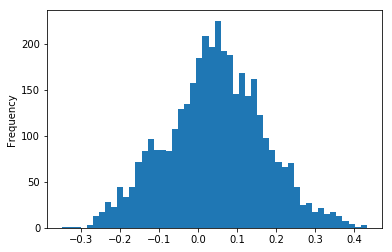

In [1372]:
Y = px_fwd_rets(df.close, ticker, pred_fwd_windows)
Y.mean(axis=1).plot.hist(bins=50)

In [1373]:
px_close[ticker].shape, px.close.shape

((3906,), (3775,))

In [1374]:
px_close[ticker].tail()

2019-03-01 00:00:00-05:00   160.62
2019-03-04 00:00:00-05:00   158.40
2019-03-05 00:00:00-05:00   157.31
2019-03-06 00:00:00-05:00   157.97
2019-03-07 00:00:00-05:00   154.10
Name: AAP, dtype: float64

In [1375]:
df = px_close[[ticker]].copy()
# df.set_index(df.index.astype(np.datetime64), inplace=True)
df.loc[:, 'weekday'] = df.index.weekday
df.weekday.unique()
df.tail(60)
df.groupby('weekday').describe()

AAP                                            
         count  mean   std   min   25%   50%    75%    max
weekday                                                   
0       707.00 81.62 49.28 22.50 39.25 65.97 127.24 200.38
1       773.00 81.81 49.40 22.64 39.03 65.99 126.79 198.70
2       777.00 81.62 49.36 22.91 38.93 66.13 126.46 199.34
3       763.00 81.76 49.24 22.40 39.30 66.18 126.68 200.34
4       756.00 81.89 49.32 22.10 39.31 66.21 127.50 198.72
5         0.00   nan   nan   nan   nan   nan    nan    nan

In [63]:
%%time
df = get_symbol_pricing(ticker)
co = px_mom_co_feats(
    df, indices_df, 
    [bench] + list(profile.loc[ticker, ['sector', 'industry']]))

NameError: name 'indices_df' is not defined

In [1393]:
co.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3906 entries, 2004-03-08 00:00:00-05:00 to 2019-03-07 00:00:00-05:00
Data columns (total 13 columns):
rsBench20     3756 non-null float64
rsSect20      3756 non-null float64
rsInd20       3756 non-null float64
rsBench60     3716 non-null float64
rsSect60      3716 non-null float64
rsInd60       3716 non-null float64
rsBench120    3656 non-null float64
rsSect120     3656 non-null float64
rsInd120      3656 non-null float64
volPctMa10    3767 non-null float64
volPctMa60    3717 non-null float64
sector        3906 non-null object
industry      3906 non-null object
dtypes: float64(11), object(2)
memory usage: 427.2+ KB


In [60]:
list(profile.loc[ticker, ['country', 'state', 'city']])
quotes.loc[ticker,:].currency

'USD'

### Full universe dataset creation

In [272]:
%%time
# Take a while ~40min to run on 1200 companies
df_raw = pd.DataFrame()
for ticker in tqdm(eqty_symbols):
    
    df = get_symbol_pricing(ticker)
    ft_df = px_mom_feats(
        df, ticker, stds, inv, incl_px, 
        sec_windows, incl_name)
    
    ft_df[y_col] = px_fwd_rets(
        df.close, ticker, pred_fwd_windows).mean(axis=1)
    
    co = px_mom_co_feats(
        df, indices_df, 
        [bench] + list(profile.loc[ticker, ['sector', 'industry']]))

    ft_df.loc[:, 'country'] = profile.loc[ticker,:].country
    ft_df.loc[:, 'currency'] = quotes.loc[ticker,:].currency
    
    ft_df = pd.concat([ft_df, co], axis=1)
    df_raw = df_raw.append(ft_df)

100%|██████████| 1207/1207 [39:29<00:00,  3.33s/it]
CPU times: user 1h 23min 47s, sys: 41min 47s, total: 2h 5min 34s
Wall time: 39min 29s


In [329]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_parquet('tmp/company-px_mom-raw')

In [312]:
df_raw = pd.read_parquet('tmp/company-px_mom-raw')

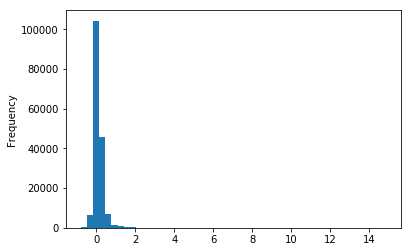

In [340]:
df_raw[y_col].plot.hist(bins=50);

In [341]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362100 entries, 2004-03-08 00:00:00-05:00 to 2019-02-18 00:00:00-05:00
Data columns (total 29 columns):
PctChg1Stds        167074 non-null float64
PctMA50            165744 non-null float64
PctMA200           164810 non-null float64
RollVol20          166870 non-null float64
PctChg5            167015 non-null float64
PctChg20           166870 non-null float64
PctChg60           165650 non-null float64
Pct52WkH           163563 non-null float64
Pct52WkL           163563 non-null float64
symbol             167074 non-null object
fwdReturn          167071 non-null float64
country            167074 non-null object
currency           167074 non-null object
rsBench20          166870 non-null float64
rsSect20           166870 non-null float64
rsInd20            166870 non-null float64
rsBench60          165650 non-null float64
rsSect60           165650 non-null float64
rsInd60            165650 non-null float64
rsBench120         165261 non

In [342]:
df_raw.describe(include='all')

,PctChg1Stds,PctMA50,PctMA200,RollVol20,PctChg5,PctChg20,PctChg60,Pct52WkH,Pct52WkL,symbol,...,rsBench120,rsSect120,rsInd120,volPctMa10,volPctMa60,benchPctChgStds,sectPctChgStds,indPctChgStds,sector,industry
count,"167,074.00","165,744.00","164,810.00","166,870.00","167,015.00","166,870.00","165,650.00","163,563.00","163,563.00",167074,...,"165,261.00","165,261.00","165,261.00","166,796.00","165,610.00","362,100.00","362,100.00","362,100.00",362100,362100
unique,nan,nan,nan,nan,nan,nan,nan,nan,nan,1037,...,nan,nan,nan,nan,nan,nan,nan,nan,11,136
top,nan,nan,nan,nan,nan,nan,nan,nan,nan,0700.HK,...,nan,nan,nan,nan,nan,nan,nan,nan,Technology,Banks - Regional - US
freq,nan,nan,nan,nan,nan,nan,nan,nan,nan,243,...,nan,nan,nan,nan,nan,nan,nan,nan,66600,17700
mean,0.05,1.03,1.07,0.45,0.01,0.04,0.11,0.73,1.88,NaN,...,0.11,0.04,0.04,0.97,0.94,0.01,0.04,0.03,NaN,NaN
std,0.99,0.13,0.27,0.31,0.07,0.15,0.32,0.22,1.42,NaN,...,0.53,0.52,0.49,0.48,0.72,0.70,0.66,0.66,NaN,NaN
min,-15.00,0.14,0.03,0.00,-0.76,-0.82,-0.90,0.01,1.00,NaN,...,-1.23,-1.12,-1.78,0.00,0.00,-3.00,-5.00,-7.00,NaN,NaN
25%,0.00,0.98,0.93,0.26,-0.02,-0.03,-0.03,0.58,1.30,NaN,...,-0.12,-0.17,-0.14,0.70,0.61,0.00,0.00,0.00,NaN,NaN
50%,0.00,1.03,1.08,0.37,0.01,0.03,0.08,0.78,1.58,NaN,...,0.03,-0.03,-0.01,0.90,0.82,0.00,0.00,0.00,NaN,NaN
75%,0.00,1.09,1.22,0.54,0.04,0.09,0.21,0.92,2.06,NaN,...,0.22,0.15,0.13,1.13,1.10,0.00,0.00,0.00,NaN,NaN


In [343]:
df_raw.dropna().describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PctChg1Stds,"163,399.00",NaN,NaN,NaN,0.05,0.99,-15.00,0.00,0.00,0.00,29.00
PctMA50,"163,399.00",NaN,NaN,NaN,1.03,0.13,0.14,0.98,1.03,1.09,4.75
PctMA200,"163,399.00",NaN,NaN,NaN,1.07,0.27,0.03,0.93,1.08,1.22,4.35
RollVol20,"163,399.00",NaN,NaN,NaN,0.45,0.31,0.00,0.26,0.38,0.55,6.26
PctChg5,"163,399.00",NaN,NaN,NaN,0.01,0.07,-0.76,-0.02,0.01,0.04,4.43
PctChg20,"163,399.00",NaN,NaN,NaN,0.04,0.15,-0.82,-0.03,0.03,0.09,4.05
PctChg60,"163,399.00",NaN,NaN,NaN,0.11,0.32,-0.90,-0.03,0.08,0.21,12.81
Pct52WkH,"163,399.00",NaN,NaN,NaN,0.73,0.22,0.01,0.58,0.78,0.92,1.00
Pct52WkL,"163,399.00",NaN,NaN,NaN,1.88,1.42,1.00,1.30,1.58,2.06,62.00
symbol,163399,1009,0700.HK,234,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pre-processing

In [ ]:
trim = 0 / 100
start = int(len(df_raw.index) * trim) 

trim_df = df_raw.iloc[start:,:].copy()
trim_df.dropna(inplace=True)

X, y = trim_df.drop(columns=y_col), trim_df[y_col]
y = column_or_1d(y, warn=True)

exp_log['trim'] = trim
exp_log['start'] = start
exp_log['X'] = log_as_dict(X)
exp_log['y'] = log_as_dict(y)

X.shape, y.shape

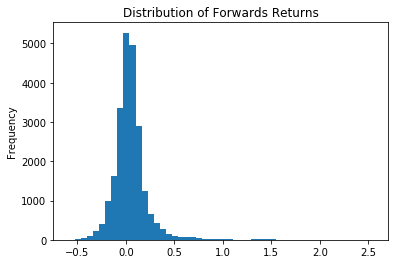

In [307]:
Y = df_raw[y_col]
Y.plot.hist(bins=50, title='Distribution of Forwards Returns')

In [308]:
df_raw.dropna(subset=[y_col], inplace=True)
# exp_log['df_raw.describe'] = log_as_dict(df_raw)
df_raw.shape

(23111, 29)

In [309]:
recent_X_lb = -252 * 4
recent_X = df_raw.iloc[recent_X_lb:,:-1].copy()

# exp_log['recent_X_lb'] = recent_X_lb
# exp_log['recent_X.describe'] = log_as_dict(recent_X)

In [311]:
drop_dates = True

if drop_dates: df_raw.reset_index(drop=True, inplace=True)
else: 
    df_raw.reset_index(inplace=True)
    df_raw.rename({'index': 'obsDate'}, axis=1, inplace=True)
    add_datepart(df_raw, 'obsDate')
    
# df_raw[[x for x in df_raw.columns if 'obs' in x]]
    
# exp_log['drop_dates'] = drop_dates
df_raw.shape

(23111, 29)

In [ ]:
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts[freq]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
df_raw[y_col] = discret_rets(df_raw[y_col], cut_range, fwd_ret_labels)

In [291]:

y_col_dist = sample_wgts(df_raw[y_col], fwd_ret_labels)
(y_col_dist[fwd_ret_labels]).round(3)

KeyboardInterrupt: 

### Train models

In [ ]:
exp_log = { 'id': int(time.time()) }
exp_log['df_raw.describe'] = log_as_dict(df_raw)

In [ ]:
exp_log['pred_fwd_windows'] = pred_fwd_windows
exp_log['bench'] = bench
exp_log['y_col'] = y_col
exp_log['cut_range'] = cut_range
exp_log['fwd_ret_labels'] = fwd_ret_labels
exp_log['df_raw.describe'] = log_as_dict(df_raw)
exp_log['y_col_dist'] = log_as_dict(y_col_dist)

In [279]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
# Mean based imputer
imputer_on = True
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
if imputer_on:
    x_cols = df_raw.columns[:-1]
    df_raw[x_cols] = imp.fit_transform(df_raw[x_cols])

exp_log['imputer_on'] = imputer_on
exp_log['imputer'] = imp.get_params()
df_raw.shape

### Old Dataset Creation

In [27]:
ds_name = 'co_price_mom_ds'
update_fmt = 'Added {} to {} dataset'

In [ ]:
%%time
# Running for entire universe takes a while
ml_ds_df = pd.DataFrame()
for s in ds_symbols:
    print(update_fmt.format(s, ds_name))
    ml_ds = co_price_mom_ds(s, px_close)
    ml_ds_df = ml_ds_df.append(ml_ds.copy(), sort=False)

In [ ]:
med_cutoff = ml_ds_df.describe().loc['50%']
ml_ds_cols = med_cutoff[med_cutoff < 3].index.tolist()
ml_ds_df = ml_ds_df[ml_ds_cols]
ml_ds_df.info()

In [50]:
# Discretize forward returns into consistent classes
class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
for c in class_cols:
    ml_ds_df[c] = pd.cut(ml_ds_df[c], cut_range, labels=fwd_ret_labels)

In [ ]:
# Drop records showing nans
ml_ds_df.dropna(inplace=True)
ml_ds_df.info()

In [ ]:
# Gut check only
ml_ds_df.hist(figsize=(15,15));

In [1171]:
print(update_fmt.format(len(ml_ds_df), ds_name))
csv_store(ml_ds_df, 'training/', csv_ext.format('co_price_mom_ds'))
ml_ds_df.to_csv(csv_ext.format('co_price_mom_ds'), index=False)

Added 489174 to co_price_mom_ds dataset
Saved training/co_price_mom_ds.csv


### Single company in one shot

In [7]:
symbol = 'AAPL'
excl_list = ['ORBK']
profile.drop(profile[profile.symbol.isin(excl_list)].index, inplace=True)

In [18]:
ml_ds = co_price_mom_ds(symbol, px_close)

In [19]:
ml_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
high,"2,516.00",94.67,50.46,12.51,54.74,89.26,124.80,233.47
low,"2,516.00",92.96,49.63,11.76,53.43,87.38,122.51,229.78
open,"2,516.00",93.84,50.04,12.03,54.15,88.44,123.50,230.78
close,"2,516.00",93.84,50.05,11.87,53.92,88.46,123.38,232.07
volume,"2,516.00","83,709,513.48","59,975,463.78","11,475,900.00","35,816,850.00","68,848,500.00","113,345,225.00","470,249,500.00"
sma20,"2,497.00",93.85,49.66,13.70,54.56,87.56,123.97,223.46
sma20ub,"2,497.00",98.34,51.93,15.72,57.64,93.10,128.86,231.21
sma20lb,"2,497.00",89.35,47.53,11.68,51.71,83.13,115.90,216.30
sma20bw,"2,497.00",0.05,0.02,0.01,0.03,0.05,0.06,0.15
pxPercStdUB,"2,497.00",-0.04,0.04,-0.23,-0.06,-0.03,-0.01,0.04


In [8]:
ml_ds_cols = cutoff_tresh_cols(ml_ds, '50%', 3)
ml_ds = ml_ds[ml_ds_cols]
ml_ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2009-02-27 to 2019-02-26
Data columns (total 24 columns):
sma20bw        2497 non-null float64
pxPercStdUB    2497 non-null float64
pxPercStdLB    2497 non-null float64
volPercMa10    2497 non-null float64
volPercMa60    2457 non-null float64
pxPercMa20     2497 non-null float64
pxPercMa50     2467 non-null float64
pxPercMa200    2317 non-null float64
chg1m          2496 non-null float64
chg3m          2456 non-null float64
chg6m          2336 non-null float64
fwdChg1w       2511 non-null float64
fwdChg1m       2496 non-null float64
fwdChg3m       2456 non-null float64
rs1mInd        2496 non-null float64
rs3mInd        2456 non-null float64
rs6mInd        2336 non-null float64
rs1mSect       2496 non-null float64
rs3mSect       2456 non-null float64
rs6mSect       2336 non-null float64
rs1mSPY        2496 non-null float64
rs3mSPY        2456 non-null float64
rs6mSPY        2336 non-null float64
fwdSSRet       2516 non-

In [87]:
class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
Xs = [x for x in ml_ds_cols if x not in class_cols]
base_name = 'ds_co_price_mom_'
for y in class_cols:
    ds_cols = Xs + [y]
    fname = base_name + y
    csv_store(ml_ds_df[ds_cols].dropna(), 'training/', csv_ext.format(fname))
    print(update_fmt.format(len(ml_ds_df), fname))

ds_co_price_mom_fwdChg1w ['sma20bw', 'pxPercStdUB', 'pxPercStdLB', 'volPercMa10', 'volPercMa60', 'pxPercMa20', 'pxPercMa50', 'pxPercMa200', 'chg1m', 'chg3m', 'chg6m', 'rs1mInd', 'rs3mInd', 'rs6mInd', 'rs1mSect', 'rs3mSect', 'rs6mSect', 'rs1mSPY', 'rs3mSPY', 'rs6mSPY', 'fwdSSRet', 'fwdChg1w']
ds_co_price_mom_fwdChg1m ['sma20bw', 'pxPercStdUB', 'pxPercStdLB', 'volPercMa10', 'volPercMa60', 'pxPercMa20', 'pxPercMa50', 'pxPercMa200', 'chg1m', 'chg3m', 'chg6m', 'rs1mInd', 'rs3mInd', 'rs6mInd', 'rs1mSect', 'rs3mSect', 'rs6mSect', 'rs1mSPY', 'rs3mSPY', 'rs6mSPY', 'fwdSSRet', 'fwdChg1m']
ds_co_price_mom_fwdChg3m ['sma20bw', 'pxPercStdUB', 'pxPercStdLB', 'volPercMa10', 'volPercMa60', 'pxPercMa20', 'pxPercMa50', 'pxPercMa200', 'chg1m', 'chg3m', 'chg6m', 'rs1mInd', 'rs3mInd', 'rs6mInd', 'rs1mSect', 'rs3mSect', 'rs6mSect', 'rs1mSPY', 'rs3mSPY', 'rs6mSPY', 'fwdSSRet', 'fwdChg3m']


In [57]:
ml_ds.iloc[-1].values

array([ 0.07520395,  0.96115697,  1.11747856,  0.83438989,  0.63417011,
        1.03343976,  1.06923453,  0.89787488,  0.1221787 , -0.02796925,
       -0.09572123,         nan,         nan,         nan,  0.4480912 ,
       -0.19057569, -0.32822912,  0.89876268, -0.15179565,  5.29095246,
        2.06532827, -0.51695119, -5.44476955,  0.03437911])

### Single company dataset step-by-step

In [1103]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [1104]:
# some clean ups
# profile.loc[profile[profile.symbol == 'ATHN'].index,:] # will happen 
# profile.drop([28], inplace=True)

In [1105]:
# Note: since the universe is limited industry and sector
# are not a good representation, need to expand universe 
# for better learning
sec_index = to_index_form(get_symbol_pricing(symbol, freq, 'close'), symbol)

symbols = profile[profile.industry == sec_industry].symbol.tolist()
industry_index = get_ind_index(px_close[symbols], '1d', tail, ind_idx_ticker)[[ind_idx_ticker]]
symbols = profile[profile.sector == sec_sector].symbol.tolist()
sector_index = get_ind_index(px_close[symbols], '1d', tail, sect_idx_ticker)[[sect_idx_ticker]]
market_index = to_index_form(get_symbol_pricing(market_etf, freq, 'close').tail(tail), market_etf)

index_df = pd.DataFrame()
index_df = index_df.append(sec_index)
index_df[ind_idx_ticker] = industry_index
index_df[sect_idx_ticker] = sector_index
index_df[market_etf] = market_index

In [1106]:
# industry, sector and market performance
row = profile[profile.symbol == symbol]
sec_sector, sec_industry = row.iloc[0].sector, row.iloc[0].industry
sec_sector, sec_industry

ind_sect_spy = index_df[[ind_idx_ticker, sect_idx_ticker, market_etf]]
index_df[['indChg1m', 'sectChg1m', 'spyChg1m']] = ind_sect_spy.pct_change(periods=20)
index_df[['indChg3m', 'sectChg3m', 'spyChg3m']] = ind_sect_spy.pct_change(periods=60)
index_df[['indChg6m', 'sectChg6m', 'spyChg6m']] = ind_sect_spy.pct_change(periods=180)

In [1107]:
# apply 20sma upper and lower std bands, # stds from file
secpx = apply_std_boundaries(secpx, 'close', 20, stds)
closepx = secpx['close']
secpx['pxPercStdUB'] = closepx / secpx['sma20ub']
secpx['pxPercStdLB'] = closepx / secpx['sma20lb']

In [1108]:
# Volume averages
volume = secpx['volume']
secpx['volMa10'] = volume.rolling(20).mean()
secpx['volMa60'] = volume.rolling(60).mean()

# volume as a % of 10 and 60 day average
secpx['volPercMa10'] = volume / secpx['volMa10']
secpx['volPercMa60'] = volume / secpx['volMa60']

# Price momentum transformations
secpx['pxMa20'] = closepx.rolling(20).mean()
secpx['pxMa50'] = closepx.rolling(50).mean()
secpx['pxMa200'] = closepx.rolling(200).mean()

# closing pricing as % of 20, 50 and 200 day average
secpx['pxPercMa20'] = closepx / secpx['pxMa20']
secpx['pxPercMa50'] = closepx / secpx['pxMa50']
secpx['pxPercMa200'] = closepx / secpx['pxMa200']

# historical returns for 1, 3, and 6 months
secpx['chg1m'] = closepx.pct_change(periods=20)
secpx['chg3m'] = closepx.pct_change(periods=60)
secpx['chg6m'] = closepx.pct_change(periods=180)

# Forward returns, 1w, 1m, 3m
secpx['fwdChg1w'] = ((closepx.shift(-5) - closepx) / closepx)
secpx['fwdChg1m'] = ((closepx.shift(-20) - closepx) / closepx)
secpx['fwdChg3m'] = ((closepx.shift(-60) - closepx) / closepx)

In [1109]:
# relative strength to industry, sector and market
secpx['rs1mInd'] = (secpx['chg1m'] / index_df['indChg1m'])
secpx['rs3mInd'] = (secpx['chg3m'] / index_df['indChg3m'])
secpx['rs6mInd'] = (secpx['chg6m'] / index_df['indChg6m'])

secpx['rs1mSect'] = (secpx['chg1m'] / index_df['sectChg1m'])
secpx['rs3mSect'] = (secpx['chg3m'] / index_df['sectChg3m'])
secpx['rs6mSect'] = (secpx['chg6m'] / index_df['sectChg6m'])

secpx['rs1mSPY'] = (secpx['chg1m'] / index_df['spyChg1m'])
secpx['rs3mSPY'] = (secpx['chg3m'] / index_df['spyChg3m'])
secpx['rs6mSPY'] = (secpx['chg6m'] / index_df['spyChg6m'])

In [1110]:
fwd_ss_ret = lambda x, df, arr:\
    df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()
# [y for y in ss_pos[7-1] if y in ss_df.index.levels[1].tolist()]
# ss_df.loc[('close'),[7, 8]]
# ss_df['close'].loc[[7,8]]

In [1111]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [1112]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: 
    ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
    
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [622]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)

### Date and Minute based time analysis

In [1007]:
freq = '1d'

In [1008]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

,close,close
count,164.00,"3,775.00"
mean,14.24,66.80
std,2.88,56.49
min,9.70,1.81
25%,12.19,16.67
50%,13.59,54.28
75%,16.51,106.82
max,21.55,232.07


In [850]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

(dict_keys(['meta', 'timestamp', 'indicators']), dict_keys(['quote']))

In [916]:
df.index.date

array([datetime.date(2019, 2, 28), datetime.date(2019, 2, 28),
       datetime.date(2019, 2, 28), ..., datetime.date(2019, 3, 6),
       datetime.date(2019, 3, 6), datetime.date(2019, 3, 6)], dtype=object)

In [851]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

DatetimeIndex(['2019-02-28 14:30:00', '2019-02-28 14:31:00',
               '2019-02-28 14:32:00', '2019-02-28 14:33:00',
               '2019-02-28 14:34:00', '2019-02-28 14:35:00',
               '2019-02-28 14:36:00', '2019-02-28 14:37:00',
               '2019-02-28 14:38:00', '2019-02-28 14:39:00',
               ...
               '2019-03-06 20:50:00', '2019-03-06 20:51:00',
               '2019-03-06 20:52:00', '2019-03-06 20:53:00',
               '2019-03-06 20:54:00', '2019-03-06 20:55:00',
               '2019-03-06 20:56:00', '2019-03-06 20:57:00',
               '2019-03-06 20:58:00', '2019-03-06 20:59:00'],
              dtype='datetime64[ns]', length=1950, freq=None)

In [829]:
df.tail(5)

,high,low,open,close,adjclose,volume
2019-03-06 20:55:00,174.72,174.60,174.66,174.71,0,"148,802.00"
2019-03-06 20:56:00,174.73,174.67,174.67,174.71,0,"37,980.00"
2019-03-06 20:57:00,174.72,174.65,174.71,174.65,0,"70,312.00"
2019-03-06 20:58:00,174.80,174.64,174.65,174.76,0,"105,856.00"
2019-03-06 20:59:00,174.82,174.46,174.74,174.51,0,"385,081.00"


In [1018]:
freq = '1d'

In [1019]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

Retrieved pricing for 0700.HK
Retrieved pricing for 1810.HK
Retrieved pricing for 3690.HK
Retrieved pricing for 9984.T
Retrieved pricing for A
Retrieved pricing for AAL
Retrieved pricing for AAN
Retrieved pricing for AAON
Retrieved pricing for AAP
Retrieved pricing for AAPL
CPU times: user 1.05 s, sys: 45.5 ms, total: 1.1 s
Wall time: 3.91 s


In [1022]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

,0700.HK,0700.HK,1810.HK,3690.HK,9984.T,A,AAL,AAN,AAON,AAP,AAPL
count,"3,634.00","3,634.00",164.00,111.00,"3,743.00","3,775.00","3,382.00","3,775.00","1,258.00","3,775.00","3,775.00"
mean,94.03,94.03,14.24,54.89,"4,406.54",33.28,26.97,23.86,28.76,81.72,66.80
std,115.76,115.76,2.88,7.61,"2,785.93",15.49,17.32,10.35,6.93,49.29,56.49
min,0.68,0.68,9.70,41.20,650.00,8.90,1.76,9.33,16.97,22.10,1.81
25%,9.51,9.51,12.19,48.45,"2,148.00",22.63,9.12,14.67,22.29,39.16,16.67
50%,40.18,40.18,13.59,55.00,"2,960.00",27.83,30.26,23.71,28.15,66.07,54.28
75%,142.08,142.08,16.51,59.82,"7,127.50",40.84,42.34,29.12,35.06,126.80,106.82
max,474.60,474.60,21.55,72.65,"11,470.00",81.24,62.95,55.45,43.83,200.38,232.07


In [1023]:
f'Ticker: {ticker}'

'Ticker: AAPL'

In [1024]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

2019-02-28 00:00:00-05:00   173.15
2019-03-01 00:00:00-05:00   174.97
2019-03-04 00:00:00-05:00   175.85
2019-03-05 00:00:00-05:00   175.53
2019-03-06 00:00:00-05:00   174.52
Name: close, dtype: float64